# Weekly Corrections

The aim of this notebook is to improve the weekly correction. It seems gamma changes a lot over time, first however I will try to make it work with a constant gamma and see if the weekly corrections change significantly over time. The analysis is related to the observation, that the fraction of positives usually increases on Mondays (i.e. results from the weekend). However, one should first determine  𝛾, and if any weekly variations remain, these should be accounted for subsequently. To do this we will divide the data up in three periods:
- September 1st - December 15th
- December 15th - January 3th (we isolate christmas, as we expect this period to be different)
- January 4th - now


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import scipy 
import datetime as dt
import scipy.stats
from scipy import stats
import iminuit
from iminuit import Minuit
from scipy.optimize import curve_fit

mpl.rcParams['font.size'] = 18      # Set the general plotting font size
plt.rc("font", family="serif")

In [2]:
save_plots = True

day_0 = '2020-09-01'
fit_to_today = False
gamma_period = ['2020-09-01', '2021-02-15']

date_start = "2020-09-01"
date_end   = "2021-03-09"

filename = 'Data-Epidemiologiske-Rapport-12032021-uh7y' #name of epidemiologisk rapport file

# Code from "MeasuringTestScalingExponent" to determine Gamma

## Read data
Note that I have not changed variable names yet, first I will see if we can get some results we can use. Later variables should be changed to P, SP and SCP.

In [3]:
data_posi = pd.read_csv(filename+"/Municipality_cases_time_series.csv", sep=';', thousands='.', index_col=0)
data_test = pd.read_csv(filename+"/Municipality_tested_persons_time_series.csv", sep=';', thousands='.', index_col=0)

# All of Denmark
if fit_to_today:
    date_end = data_test.index[-1]
    
Nposi_all = data_posi.loc[date_start:date_end].sum(axis=1)
eNposi_all = np.sqrt(Nposi_all)
Ntest_all = data_test.loc[date_start:date_end].sum(axis=1)
eNtest_all = np.sqrt(Ntest_all)
day  = np.arange(1,len(Nposi_all)+1)

# Number of positive tests and uncertainty, assuming fixed number of daily tests and power law correction:
Power = 0.56         # Power in power law for the increase in positives with increase in tests.
SystError = 0.000   # To account for larger uncertainties on fraction positives than simply the statistical.

# TP 6. March: Are the above necessary? And the below scaling (yet)?

nAveDailyTests_all = Ntest_all.mean()
print("Average number of PCR tests: ", nAveDailyTests_all)
fPos_all = Nposi_all / Ntest_all
nPos_all  = Nposi_all * (Ntest_all / nAveDailyTests_all)**(-Power)
enPos_all = np.sqrt(Ntest_all*fPos_all*(1-fPos_all) ) * (Ntest_all / nAveDailyTests_all)**(-Power) 

Average number of PCR tests:  80992.6105263158


## Define ranges, fitting function, and model:

In [4]:
Plot_StartDay = 1
Plot_EndDay   = 63

Fit_StartDay  = 0
Fit_EndDay    = 33
day1jan       = np.arange(Plot_StartDay, Plot_EndDay)
day1jan_fit   = np.arange(Fit_StartDay, Fit_EndDay)
Npoints = len(day1jan_fit)

day_extrapol = 20

### Comparison of geometric mean with scaled positives
First we define a likelihood for comparingf geometric mean of scaled positives and scaled positives with variable scaling, $\gamma$. Then best fit and uncertainty on gamma within time-period is defined

In [5]:
def model_bllh_og(N_obs, N_exp):
    p_cdf = np.zeros_like(N_exp)
    p_cdf[N_obs < N_exp]  = scipy.stats.poisson.logcdf( N_obs[N_obs < N_exp], N_exp[N_obs < N_exp] )
    p_cdf[N_obs >= N_exp] = scipy.stats.poisson.logsf(  N_obs[N_obs >= N_exp], N_exp[N_obs >= N_exp] )
    return - 2 * sum( (p_cdf) )

def model_bllh(N_obs, N_exp):
    p_cdf = np.zeros_like(N_exp)
    p_cdf  = scipy.stats.poisson.logcdf( N_obs, N_exp )
    p_cdf[p_cdf >= np.log(0.5)] = scipy.stats.poisson.logsf(  N_obs[p_cdf >= np.log(0.5)], N_exp[p_cdf >= np.log(0.5)] )
    return - 2 * sum( (p_cdf) )

#Find likelihood of N_obs given N_exp with poisson statistics

def gamma_index(): #finds best fit gamma and uncertainty for period
    llh_list = []
    gamma_list = np.linspace(0,1.,101) #probe gamma in discrete values. 
    for gamma in gamma_list:
        nPos_all  = Nposi_all * (Ntest_all / nAveDailyTests_all)**(-gamma)
        enPos_all = np.sqrt(Nposi_all * (Ntest_all / nAveDailyTests_all)**(-gamma) )
    
        y = nPos_all[Plot_StartDay:Plot_EndDay]
        y_exp = []
        for i in range(3,len(y)-3):
            y_exp.append( (np.prod(y[i-3:i+4]))**(1/7) ) 
            #Geometric running average, predicted scaled positive test number
            
        llh = model_bllh( np.array(nPos_all[Plot_StartDay+4:Plot_EndDay-2].values), np.array(y_exp) )
        llh_list.append(llh)     
    min_llh = min(llh_list)

    
    p = np.polyfit(gamma_list[np.isclose(llh_list, min_llh, atol=10.)], 
               np.array(llh_list)[np.isclose(llh_list, min_llh, atol=10.)], 2)
    gamma = -p[1]/(2*p[0])
    dgamma = 1/np.sqrt(p[0]) #fit parabola fit intercept with 1 sigma
    
    return gamma, dgamma, llh_list, gamma_list, nPos_all, enPos_all, y_exp

#gamma, dgamma, llh_list, gamma_list, nPos_all, enPos_all, y_exp = gamma_index()

### Compare $\gamma (t)$
Compute $\gamma (t)$ as a linear function using locally computed geometric mean

In [6]:
gamma_t = []
dgamma_t = []

days_between_points = 7
for i in np.arange(0,len(data_posi.loc[date_start:date_end].sum(axis=1)) - 28,days_between_points): 
    #loop over every days_between_points days from september to february
    Nposi_all = data_posi.loc[date_start:date_end].sum(axis=1)
    eNposi_all = np.sqrt(Nposi_all)
    Ntest_all = data_test.loc[date_start:date_end].sum(axis=1)
    eNtest_all = np.sqrt(Ntest_all)
    day  = np.arange(1,len(Nposi_all)+1)

    Plot_StartDay = i
    Plot_EndDay   = 28+i

    nAveDailyTests_all = Ntest_all.mean()
    fPos_all = Nposi_all / Ntest_all

    gamma, dgamma, llh_list, gamma_list, nPos_all, enPos_all, y_exp = gamma_index()
    gamma_t.append(gamma), dgamma_t.append(dgamma)

Here we plot $\gamma(t)$. There are some problems with the week lines, that don't align since gamma is only determined every seven days. For now I have just removed the week lines.

In this section we furthermore compute the average gamma for each period, called ``g1, g2, g3``. Notice also when I compute the average for each period, I manually plug in the numbers of how many of the gamma points should be included. This should be automatic, but I cant figure it ut right now and don't want to waste to much time on it if it doesnt work.

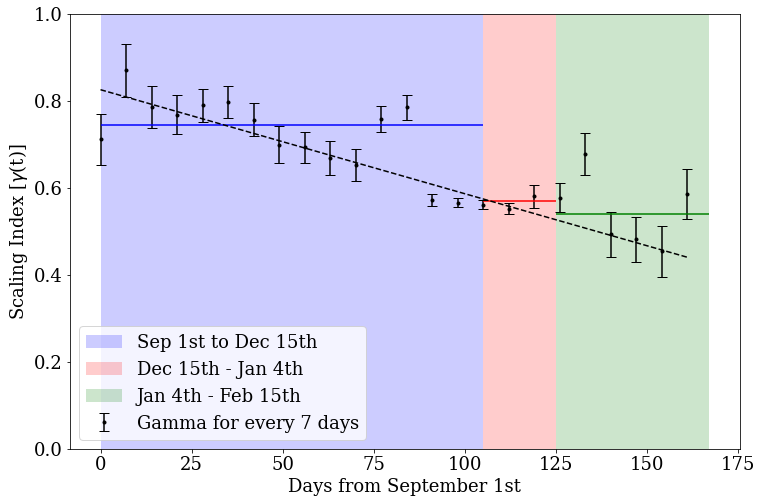

In [21]:
#plot data
plt.figure(figsize=(12,8))
plt.errorbar(days_between_points*np.arange(len(gamma_t)), gamma_t, yerr=dgamma_t, fmt='.', capsize=5, color='k', label=f'Gamma for every {days_between_points} days')
days = days_between_points*np.arange(len(gamma_t)) 
plt.ylabel(r'Scaling Index [$\gamma$(t)]')#, plt.xlabel('Days from '+date_start)
plt.ylim(0,1)#, plt.legend() 

#fit linear function
def lin(x,a,b):
    return a*x+b
p, cov = curve_fit(lin, days, gamma_t, sigma=dgamma_t)
power = lin(np.arange(3,len(Nposi_all[date_start:date_end])-4), *p)

#plot fit
plt.plot(days, lin(days, *p), color='k', linestyle='dashed')

#This creates weekly lines
#now = dt.date(year=int(date_end[:4]), month = int(date_end[5:7]), day = int( date_end[8:] ))
#then = now + dt.timedelta(days=-(len(data_posi.loc[date_start:date_end].sum(axis=1)))+14 )
#for x in np.arange(0,165,7): #weeks
#    plt.axvline( x, ls='--', color='grey', alpha=0.2)    
# Plot monthly lines on first date
#d_now = dt.date(year=int(date_start[:4]), month = int(date_start[5:7]), day = int( date_start[8:] ))
#for i in range(len(data_posi.loc[date_start:date_end].sum(axis=1))):
#    d_now = d_now + dt.timedelta(days=1)
#    if d_now.day == 1:
#        plt.axvline( i-12, ls='-', color='k', alpha=0.5)
    
#times = []; N_weeks = int(len(data_posi.loc[date_start:date_end].sum(axis=1))/14)
#for i in range(N_weeks):
#    times.append(then + dt.timedelta(days=14*i))
    
#plt.xticks(ticks=[14*i for i in range(N_weeks)], 
#           labels=[str(time.year)+'-'+str(time.month)+'-'+str(time.day) for time in times], rotation=30 );

#Mark the three periods ------------------------------------------------------------------
period1 = (0, (dt.date(2020, 12, 15)-dt.date(2020, 9, 1)).days )
plt.axvspan(*period1, facecolor='b', alpha=0.2, label='Sep 1st to Dec 15th')

period2 = ( period1[1], period1[1] + (dt.date(2021, 1, 4)-dt.date(2020, 12, 15)).days )
plt.axvspan(*period2, facecolor='r', alpha=0.2, label='Dec 15th - Jan 4th')

period3 = ( period2[1], period2[1] + (dt.date(2021, 2, 15)-dt.date(2021, 1, 4)).days )
plt.axvspan(*period3, facecolor='g', alpha=0.2, label='Jan 4th - Feb 15th')

plt.legend()
plt.xlabel('Days from September 1st')

# Find a constant gamma for each period  ------------------------------------------------- 
g1 = np.average(a=gamma_t[0:15], weights=dgamma_t[0:15])
g1_std = np.std(a=gamma_t[0:15])
plt.hlines(g1, *period1, color='b')

g2 = np.average(a=gamma_t[15:18], weights=dgamma_t[15:18])
g2_std = np.std(a=gamma_t[15:18])
plt.hlines(g2, *period2, color='r')

g3 = np.average(a=gamma_t[18:24], weights=dgamma_t[18:24])
g3_std = np.std(a=gamma_t[18:24])
plt.hlines(g3, *period3, color='g')

plt.show()
#plt.savefig('gamma_t_2.png', dpi=300)

Now we will plot the entire period, and mark the three periods.

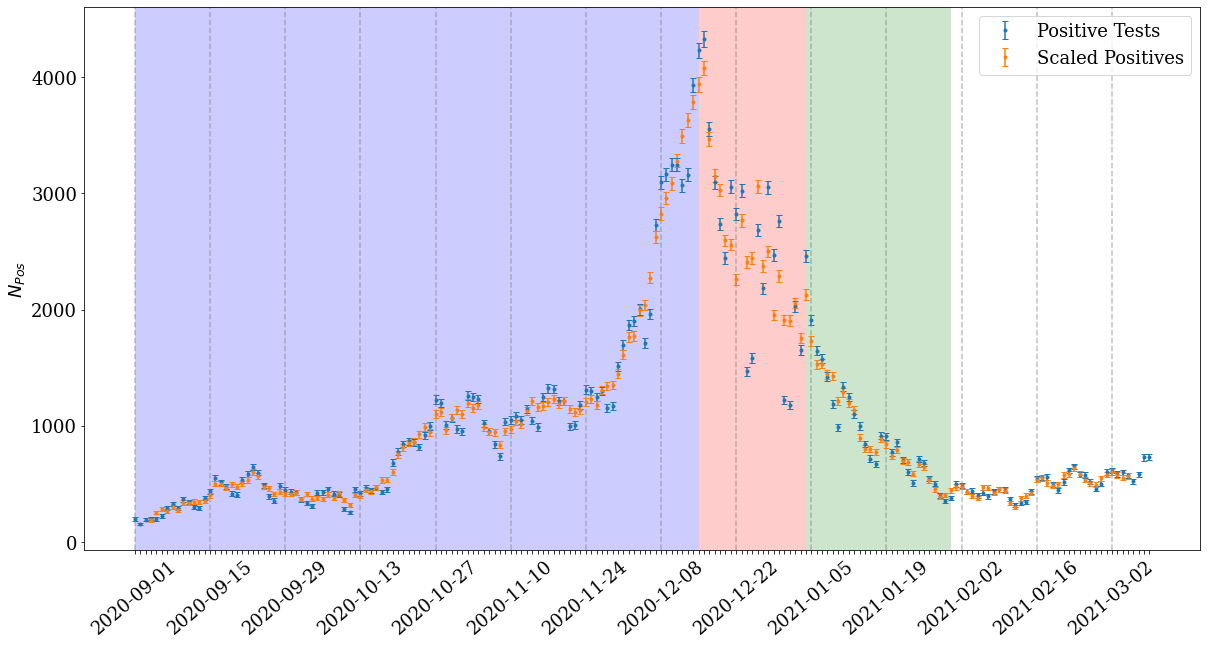

In [22]:
plt.figure(figsize=(20,10))
plt.errorbar(Nposi_all.index, Nposi_all[date_start:date_end], 
             yerr = eNposi_all[date_start:date_end], fmt='.', capsize=3, label='Positive Tests')

#includes date on x-label
ax = plt.gca()
temp = ax.xaxis.get_ticklabels()
temp = list(set(temp) - set(temp[::14]))
for label in temp:
    label.set_visible(False)
for x in np.arange(0,len(Nposi_all[date_start:date_end]),14): #weeks
    plt.axvline( x, ls='--', color='grey', alpha=0.5)
    
    
mean_arr = []
for i in np.arange(3,len(Nposi_all[date_start:date_end])-4): 
    mean_arr.append( np.mean(Ntest_all[date_start:date_end][i-3:i+4]) )
SP = Nposi_all[3:-4] * (Ntest_all[date_start:date_end][3:-4]/mean_arr)**(-np.asarray(power) )


plt.errorbar(SP.index, SP[date_start:date_end], 
             yerr = np.sqrt(SP[date_start:date_end]), fmt='.', capsize=3, label='Scaled Positives')
plt.ylabel(r'$N_{Pos} $')
plt.xticks(rotation = 40); plt.legend();

#Mark the three periods ------------------------------------------------------------------
period1 = (0, (dt.date(2020, 12, 15)-dt.date(2020, 9, 1)).days )
plt.axvspan(*period1, facecolor='b', alpha=0.2, label='Sep 1st to Dec 15th')

period2 = ( period1[1], period1[1] + (dt.date(2021, 1, 4)-dt.date(2020, 12, 15)).days )
plt.axvspan(*period2, facecolor='r', alpha=0.2, label='Dec 15th - Jan 4th')

period3 = ( period2[1], period2[1] + (dt.date(2021, 1, 31)-dt.date(2021, 1, 4)).days )
plt.axvspan(*period3, facecolor='g', alpha=0.2, label='Jan 4th - Jan 31st')

plt.show()
#plt.savefig('Scaled_pos.png', dpi=300)

# Weekly corrections with weighted chi2 mean
Now that we have determined gamma we can look to determine the weekly corrections. We have gamma as a linear function, where the varying values of gamma are saved in the variable ``power``. Furthermore we have (from another script? that if we chose gamma to constant it is assigned the value of -0.56). I have also determined an average gamma for each period. We will start by looking into the last to options of use of gamma.

## With a value of gamma for each period.
First we need to define a function that can find the weekly corrections. The idea behind the weekly correction is that no one day is special. Say we want to correct a given day, we use the three days before and the three days after, and find a weighted average of how many scaled positives we would expect that day ``N_exp``, and compare it to how many scaled positives observed that day ``N_obs``. We can then find the correction as:
$$ corr = \frac{N_{obs}-N_{exp}}{N_{exp}} $$
When we implement it we should therefor multiply by $1-corr$

If we do this for all days in each period (minus 3 on each side ?), we will get a table we can divide into the 7 weekdays. For all mondays in the period we will have a list of corrections along with their uncertainty, we can then compute a weighted average of those to obtain a correction factor for each day. This correction can be used on later data by multiplying with ``1-correction``.

As a sanity check we will plot the correction for each week on top of each other to see if they change significantly from one period to another.

In [23]:
g3_std # we will use this for now as the error on g3

0.07657499206230552

In [35]:
# Perform error propagation on SP_obs we need to use later (just functions I copied from my work in AppStat)
from sympy import*
def value_error_contribution_func_gen(expr, variables):
    """
    expr = takes in a math expression in a string of type 'a+b'
    var = takes in a tuple of variables strings, fx ('a', 'b') 
    """
    # Convert expression into a sympy expression
    expr = parse_expr(expr)
    
    # Define sympy symbols for the parameters (the tuple variables) and the standard deviations
    var_symbols = symbols(variables)
    err_symbols = symbols( tuple("sigma_" + k for k in variables) )
    
    # Find expressions for each contributions
    contributions = [expr.diff(var) ** 2 * err**2 for var, err in zip(var_symbols, err_symbols)]
    
    # Convert contributions to numerical functions
    f_contributions = [ lambdify(var_symbols + err_symbols, expression) for expression in contributions ]

    # Find the error propagation expression to be evaluated, and display
    expr_sig = sqrt( sum(contributions) )
    display(expr_sig)
    
    # Convert the expression for the value and the error into numerical functions
    f_val = lambdify(var_symbols, expr)
    f_err = lambdify(var_symbols + err_symbols, expr_sig)
    
    def func(**kwargs):
        """
        Define a function that will take in keywordarguments **kwargs which is a dictionary of type: 
        {'a':(1,0.1), 'b':(2,0.3)}. Kwargs.values calls the two tuples as one list [(1,0.1),(2,0.3)].
        From there an array of variables and an array of errors can be extracted and the numerical
        functions found above can be used.
        
        """
        # Create tuple of values of variables
        v = tuple(v[0] for v in kwargs.values())
        
        # Create tuple of errors of variables
        s = tuple(v[1] for v in kwargs.values())
        
        # Calculate value and error
        value, error = f_val(*v), f_err(*v, *s)

        # Calculate contribution from each variable
        contr_list = [ function(*v,*s) for function in f_contributions ]
        
        #Return value and analytical error
        return value, error, contr_list
    
    # Return the main function that we set out to generate
    return func


# Define function that gets variables from **kwargs and uses the function above to return value and error
def val_err_contr(expr, **kwargs):
    """
    INPUT:
    expr = takes in a math expression in a string of type 'a+b'
    **kwargs = variable names = (value, error) of type a=(3, 0.3)
    
    Note that if the relation depends on constant, type those in as variables with sigma = zero.
    
    
    OUTPUT:
    value = integer
    error = integer
    contributions = array_like with contributions from each variable in the same order as in the input
    """
    
    return value_error_contribution_func_gen(expr, tuple(kwargs))(**kwargs)

# ERROR ON SP_OBS: P = P_all, T = T_all, m = T_mean, g = gamma
print('SP_obs error')
_, _, _ = val_err_contr('P * (T / m)**(-g)', P=(1,1), T=(1,1), m=(1,1), g=(1,1))


print('Frac corr error')
_, _, _ = val_err_contr('(SP_obs - SP_exp)/SP_exp', SP_obs=(1,1), SP_exp=(1,1) )

SP_obs error


sqrt(P**2*g**2*sigma_m**2*(T/m)**(-2*g)/m**2 + P**2*sigma_g**2*(T/m)**(-2*g)*log(T/m)**2 + P**2*g**2*sigma_T**2*(T/m)**(-2*g)/T**2 + sigma_P**2*(T/m)**(-2*g))

Frac corr error


sqrt(sigma_SP_exp**2*(-1/SP_exp - (-SP_exp + SP_obs)/SP_exp**2)**2 + sigma_SP_obs**2/SP_exp**2)

This is the expression for the error on SP and error on the fractional correction for each day^^

In [38]:
def week_correction(dato_start, dato_end, gamma, egamma, region=None):
    """
    dato_start, dato_end = start day and en day of period we will analise. On the form 'year-month-date'.
                           Notice the corrections we will calculate will remove three days from each side
                           of this period to be able to compute the geometric mean
    gamma = the power for the given period. Constant.
    egamma = error on gamma
    region = list of regions to include in the data, if none all is included.
    """
    
    # Define a mask that includes all regions, if regions is not passed
    if not region:
        region = np.ones_like(data_posi.loc[dato_start:dato_end].sum(axis=1), dtype=bool)
    
    # Extract data from the time period
    P_all = data_posi.loc[dato_start:dato_end][region].sum(axis=1)
    eP_all = np.sqrt(P_all)
    
    T_all = data_test.loc[dato_start:dato_end][region].sum(axis=1)
    eT_all = np.sqrt(T_all)
    
    T_mean = T_all.mean()
    eT_mean = np.std(T_all) / len(T_all) #error on mean as sigma/n

    # Find observed scaled positives
    SP_obs = P_all * (T_all/T_mean)**(-gamma)
    eSP_obs = np.sqrt( (P_all**2 * gamma**2 * eT_mean**2 * (T_all/T_mean)**(-2*gamma))/T_mean**2 \
                     + P_all**2 * egamma**2 * (T_all/T_mean)**(-2*gamma) * np.log(T_all/T_mean)**2 \
                     + (P_all**2 * gamma**2 * eT_all**2 * (T_all/T_mean)**(-2*gamma))/T_all**2 \
                     + eP_all**2 * (T_all/T_mean)**(-2*gamma) )
    
    # Find expected scaled positives as the geometric mean of three days on each side
    SP_exp = np.zeros_like(SP_obs[6:]) #remove the six days on each day we dont use
    eSP_exp = np.zeros_like(SP_obs[6:])
    
    n = 7 #number of days we compute the mean from = 2*3+1

    for i in np.arange(3,len(SP_obs)-3): 
        
        # Geometric mean
        SP_exp[i-3] = (np.prod(SP_obs[i-3:i+4]))**(1/n) 
        
        # Error on geometric mean - from https://en.wikipedia.org/wiki/Geometric_standard_deviation
        eSP_exp[i-3] = np.exp( np.sqrt( np.sum( np.log(SP_obs[i-3:i+4])**2/n ) ) )
    
    # Fractional corrections --------------------------------------------------------------
    
    # Find number of weeks (rows in our matrix of size (weeks,7) ): +1 to make sure we have enough
    nrows = len(SP_exp) // 7 + 1

    # Create arrays with nan, so elements not filled in will not contribute to the weighted average
    SP_obs_arr = np.empty(nrows * 7)
    SP_obs_arr[:] = np.nan
    
    eSP_obs_arr = np.empty(nrows * 7)
    eSP_obs_arr[:] = np.nan
    
    SP_exp_arr = np.empty(nrows * 7)
    SP_exp_arr[:] = np.nan
    
    eSP_exp_arr = np.empty(nrows * 7)
    eSP_exp_arr[:] = np.nan
    
    # Find out which day of the week, the first element is (should be dato_start+3)
    first_weekday = dt.date(int(dato_start[:4]), int(dato_start[5:7]), int(dato_start[8:10])) + dt.timedelta(days=3)
    day_index = first_weekday.weekday() #this would be the index where to insert the first element
    
    # Fill in SP_obs and SP_exp into empty array so they will have the right shape, ie. if we start on a 
    # thursday the first 3 values will be np.nan    
    SP_obs_arr[day_index:day_index+len(SP_exp)] = SP_obs[3:-3]
    eSP_obs_arr[day_index:day_index+len(SP_exp)] = eSP_obs[3:-3]
    
    SP_exp_arr[day_index:day_index+len(SP_exp)] = SP_exp
    eSP_exp_arr[day_index:day_index+len(SP_exp)] = eSP_exp
    
    # Lets reshape the array into matrices of the form week x day
    SP_obs_mat = SP_obs_arr.reshape(nrows, 7)
    eSP_obs_mat = eSP_obs_arr.reshape(nrows, 7)
    
    SP_exp_mat = SP_exp_arr.reshape(nrows, 7)
    eSP_exp_mat = eSP_exp_arr.reshape(nrows, 7)
    
    # Find fractional correction for each weekday with error propagation obtain error too
    corr = (SP_obs_mat - SP_exp_mat) / SP_exp_mat
    ecorr = np.sqrt( eSP_exp_mat**2 * ( -1/SP_exp_mat-(-SP_exp_mat+SP_obs_mat)/SP_exp_mat**2)**2 \
                    + eSP_obs_mat**2/SP_exp_mat**2  )
    
    # Lets display what we have gotten so far in a imshow plot, each column should be the same color ish
    # if not there are big deviations, we all show the errors on the corrections
    fig, ax = plt.subplots(ncols=2, figsize=(12,5))
    im = ax[0].imshow( corr )
    fig.colorbar(im, ax=ax[0])
    ax[0].set_title('Corrections')
    im2 = ax[1].imshow( ecorr )
    fig.colorbar(im2, ax=ax[1])
    ax[1].set_title('Errors on corr')
    
    # Perform chi2 weighted average for each column ----------------------------------------
    avg = np.nansum( (corr / ecorr**2) / np.nansum( 1 / ecorr**2, axis = 0 ), axis=0 )
    eavg = np.sqrt( 1 / np.nansum(1 / ecorr**2, axis=0) ) 
    
    # Find degrees of freedom (-1 )
    N_dof = np.count_nonzero((~np.isnan(corr)), axis=0) - 1 #counts number of non nan elements in each column

    # Calculate chi_square
    chi2 = np.nansum( (corr - avg)**2 / ecorr**2, axis=0 )
    
    # Calculate p-value (the integral of the chi2-distribution from chi2 to infinity)
    p = stats.chi2.sf(chi2, N_dof)
    
    # Find mean of the fractional correction for each weekday, ie along the axis 0 = rows
    mean = np.nanmean( (SP_obs_mat - SP_exp_mat) / SP_exp_mat , axis=0)   #monday, tuesday, wednesday etc.
    n_days = np.count_nonzero((~np.isnan(SP_obs_mat)), axis=0) #counts number of non nan elements in each column
    std = np.nanstd( (SP_obs_mat - SP_exp_mat) / SP_exp_mat , axis=0) / np.sqrt(n_days-1)
    
    print('Chi2:', chi2)
    print('P værdi:', p)
    print('Weighted chi2 avg:', avg)
    print('Alm mean vi tidligere brugte som correction', mean)
    
    return mean, std #should return which method we deem the best

Chi2: [0.02896177 0.02025369 0.05950851 0.05358183 0.02394649 0.0294776
 0.0736605 ]
P værdi: [1. 1. 1. 1. 1. 1. 1.]
Weighted chi2 avg: [-0.02320809  0.00921964  0.03940042 -0.00429304 -0.01052289  0.0154414
 -0.04440477]
Alm mean vi tidligere brugte som correction [-0.01914086  0.01214777  0.04827257  0.00350983 -0.0073752   0.01953519
 -0.03416093]
Chi2: [0.00839016 0.00027944 0.00020223 0.00012169 0.00075611 0.03637405
 0.00947465]
P værdi: [0.92701759 0.98666281 0.98865399 0.99119851 0.99962202 0.8487451
 0.92245812]
Weighted chi2 avg: [-0.00500992 -0.13074959  0.06229374 -0.04417601 -0.02329621  0.0857488
 -0.06712794]
Alm mean vi tidligere brugte som correction [ 0.00347335 -0.13051513  0.06252077 -0.04405409 -0.02281831  0.12672008
 -0.05817421]
Chi2: [0.00754188 0.00466768 0.01865383 0.03303223 0.04615031 0.0315334
 0.02525759]
P værdi: [0.99999291 0.99999728 0.99995677 0.99998958 0.99997606 0.999877
 0.99992092]
Weighted chi2 avg: [ 0.06663516  0.09579552  0.02853791 -0.082249

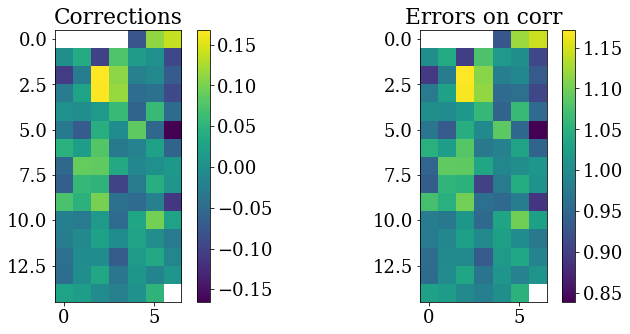

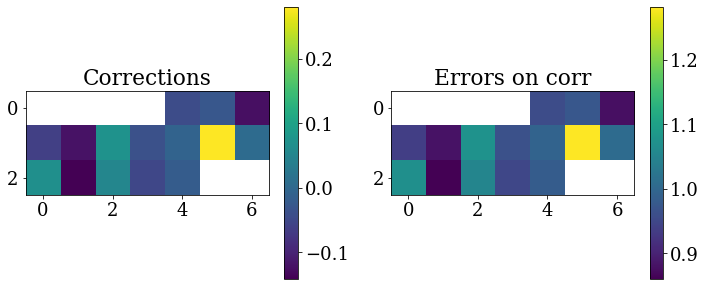

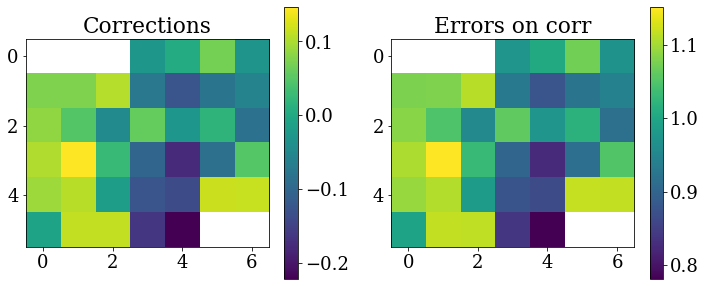

In [39]:
# Use on the first period
f1, e1 = week_correction(dato_start='2020-09-01', dato_end='2020-12-15', gamma=g1, egamma=g1_std)

# Use on the second period
f2, e2 = week_correction(dato_start='2020-12-15', dato_end='2021-01-04', gamma=g2, egamma=g2_std)

# Use on the third period
f3, e3 = week_correction(dato_start='2021-01-04', dato_end='2021-02-15', gamma=g3, egamma=g3_std)

In [40]:
# print korrektionerne
f1, f2, f3 # de gamle korrektioner

(array([-0.01914086,  0.01214777,  0.04827257,  0.00350983, -0.0073752 ,
         0.01953519, -0.03416093]),
 array([ 0.00347335, -0.13051513,  0.06252077, -0.04405409, -0.02281831,
         0.12672008, -0.05817421]),
 array([ 0.06977242,  0.09790363,  0.03645711, -0.07185984, -0.11346795,
         0.00791217, -0.00158532]))

In [41]:
def week_corr_plotter(mean, std, ax, lbl=None, col='blue'): 
    
    ax.errorbar(np.arange(len(mean)), mean, yerr=std, fmt='.', capsize=10, label=lbl, color=col)
    ax.legend()
    ax.set_ylabel('Fractional Deviation')
    ax.hlines(0, 0, 6, ls='--', color='k')
    plt.xticks([0,1,2,3,4,5,6], ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'], rotation=25);

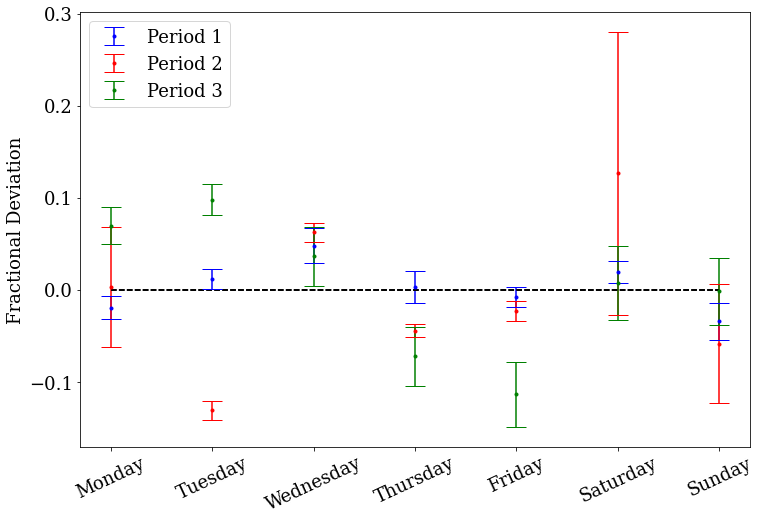

In [30]:
fig, ax = plt.subplots(figsize=(12,8))
week_corr_plotter(f1, e1, ax,'Period 1', col='blue')
week_corr_plotter(f2, e2, ax,'Period 2', col='red')
week_corr_plotter(f3, e3, ax,'Period 3', col='green')

Chi2: [0.00754188 0.00466768 0.01865383 0.03303223 0.04615031 0.0315334
 0.02525759]
P værdi: [0.99999291 0.99999728 0.99995677 0.99998958 0.99997606 0.999877
 0.99992092]
Weighted chi2 avg: [ 0.06663516  0.09579552  0.02853791 -0.08224909 -0.12712293 -0.00480165
 -0.01186687]
Alm mean vi tidligere brugte som correction [ 0.06977242  0.09790363  0.03645711 -0.07185984 -0.11346795  0.00791217
 -0.00158532]


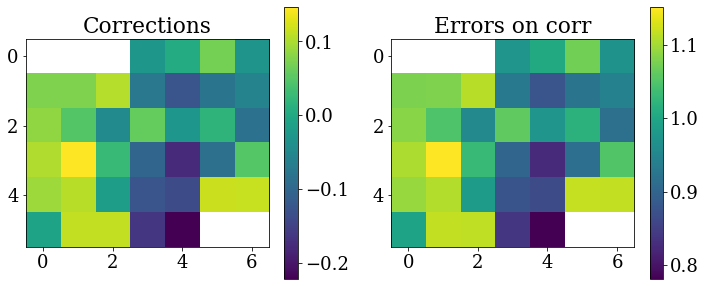

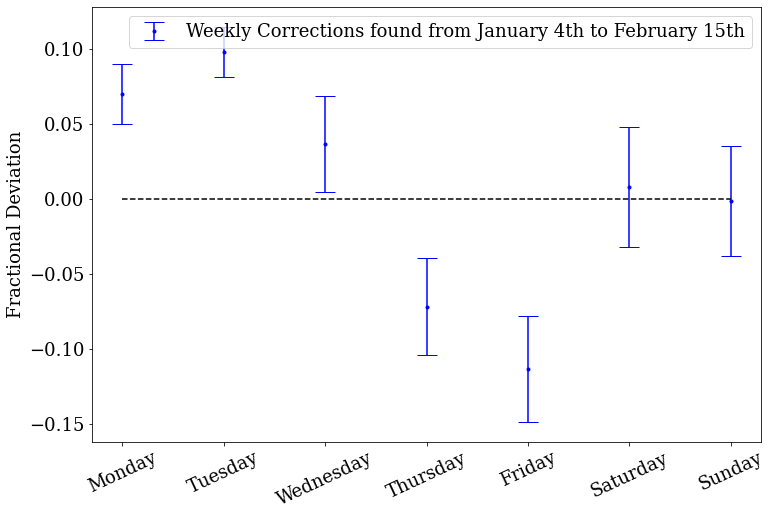

In [42]:
# Use on the third period
f3, e3 = week_correction(dato_start='2021-01-04', dato_end='2021-02-15', gamma=g3, egamma=g3_std)
fig, ax = plt.subplots(figsize=(12,8))
week_corr_plotter(f3, e3, ax,'Weekly Corrections found from January 4th to February 15th', col='blue')

De ting der er vist ovenfor (de ugentlige korrektioner som printes og som plottes) er dem der opstår ved det alm mean. Det ligner der stadig er noget ved det vægtede gennemsnit der skal kigges på inden vi kan bruge den.

# Gamle week correction function med alm mean (uden chi2)

In [43]:
def week_correction_old(dato_start, dato_end, gamma):
    """
    dato_start, dato_end = start day and en day of period we will analise. On the form 'year-month-date'.
                           Notice the corrections we will calculate will remove three days from each side
                           of this period to be able to compute the geometric mean
    gamma = the power for the given period. Constant.
    """
    
    # Extract data from the time period
    P_all = data_posi.loc[dato_start:dato_end].sum(axis=1)
    eP_all = np.sqrt(P_all)
    
    T_all = data_test.loc[dato_start:dato_end].sum(axis=1)
    eT_all = np.sqrt(T_all)
    T_mean = T_all.mean()
    
    # Find mean of tests performed, to use as T in the formula to find scaled positives SP
    # The mean is found by looking at three days on each side
        #mean_arr = []
        #for i in np.arange(3, len(P_all)-4): 
        #mean_arr.append( np.mean(T_all[i-3:i+4]) )
    
    # Find observed scaled positives
    SP_obs = P_all * (T_all/T_mean)**(-gamma)
    
    # Find expected scaled positives as the geometric mean of three days on each side
    SP_exp = np.zeros_like(SP_obs[6:]) #remove the six days on each day we dont use
    eSP_exp = np.zeros_like(SP_obs[6:])
    
    n = 7 #number of days we compute the mean from = 2*3+1

    for i in np.arange(3,len(SP_obs)-3): 
        
        # Geometric mean
        SP_exp[i-3] = (np.prod(SP_obs[i-3:i+4]))**(1/n) 
        
        # Error on geometric mean - from https://en.wikipedia.org/wiki/Geometric_standard_deviation
        eSP_exp[i-3] = np.exp( np.sqrt( np.sum( np.log(SP_obs[i-3:i+4])**2/n ) ) )
    
    # Fractional corrections --------------------------------------------------------------
    
    # Find number of weeks (rows in our matrix of size (weeks,7) ): +1 to make sure we have enough
    nrows = len(SP_exp) // 7 + 1

    # Create two arrays with nan, so elements not filled in will not contribute to the weighted average
    SP_obs_arr = np.empty(nrows * 7)
    SP_obs_arr[:] = np.nan
    
    SP_exp_arr = np.empty(nrows * 7)
    SP_exp_arr[:] = np.nan
    
    # Find out which day of the week, the first element is (should be dato_start+3)
    first_weekday = dt.date(int(dato_start[:4]), int(dato_start[5:7]), int(dato_start[8:10])) + dt.timedelta(days=3)
    day_index = first_weekday.weekday() #this would be the index where to insert the first element
    
    # Fill in SP_obs and SP_exp into empty array so they will have the right shape, ie. if we start on a 
    # thursday the first 3 values will be np.nan    
    SP_obs_arr[day_index:day_index+len(SP_exp)] = SP_obs[3:-3]
    SP_exp_arr[day_index:day_index+len(SP_exp)] = SP_exp
    
    # Lets reshape the array into matrices of the form week x day
    SP_obs_mat = SP_obs_arr.reshape(nrows, 7)
    SP_exp_mat = SP_exp_arr.reshape(nrows, 7)
    
    # Lets display what we have gotten so far in a imshow plot, each column should be the same color ish
    # if not there are big deviations
    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow( (SP_obs_mat - SP_exp_mat) / SP_exp_mat )
    fig.colorbar(im)
    
    # Find mean of the fractional correction for each weekday, ie along the axis 0 = rows
    mean = np.nanmean( (SP_obs_mat - SP_exp_mat) / SP_exp_mat , axis=0)   #monday, tuesday, wednesday etc.
    n_days = np.count_nonzero((~np.isnan(SP_obs_mat)), axis=0) #counts number of non nan elements in each column
    std = np.nanstd( (SP_obs_mat - SP_exp_mat) / SP_exp_mat , axis=0) / np.sqrt(n_days-1)
    
    return mean, std

# Weekly corrections land versus by versus hovedstaden

Vi har en ide om at de ugentlige korrektioner måske afhænger af hvilken region man befinder sig i, i og med at adfærdsmønstrene måske er forksellige afhængig af region. Først prøver vi derfor at opdele dataet, så vi kan bruge vores weekly_corrections function på kategorierne hver for sig.

In [44]:
#Split data into Capital region, City regions and country regions

# Capital region defined as Storkøbenhavn, seen in: 
# http://smilingcopenhagen.dk/turist?City=All&area=Greater_Copenhagen&Go=Capital_Region_of_Denmark&Art=0&Visit=Denmark&Re=Europe&Book=area
capital = ["Copenhagen", "Frederiksberg", "Gentofte", "Dragør", "Ballerup", "Gladsaxe", "Herlev", "Hvidovre" \
          , "Brøndby", "Tårnby", "Vallensbæk", "Rødovre", "Glostrup","Høje-Taastrup", "Ishøj","Albertslund"]

city = ["Aarhus", "Esbjerg", "Odense", "Aalborg"]

country = ["Kalundborg", "Middelfart", "Allerød", "Helsingør", "Hillerød", "Rudersdal", "Næstved" \
           , "Favrskov", "Frederikssund", "Furesø", "Holbæk", "Kolding","Silkeborg","Skanderborg","Vejle" \
           ,"Aabenraa", "Faxe","Fredericia","Faaborg-Midtfyn", "Guldborgsund","Haderslev","Halsnæs" \
           , "Herning","Horsens", "Hørsholm","Lolland","Lyngby-Taarbæk","Nordfyns","Nyborg","Randers" \
           ,"Skive","Slagelse","Sorø", "Svendborg","Syddjurs","Sønderborg","Vejen","Viborg","Vordingborg" \
           ,"Billund", "Gribskov","Holstebro","Kerteminde","Mariagerfjord","Norddjurs","Odder" \
           , "Odsherred","Ringkøbing-Skjern","Morsø","Thisted","Tønder", "Assens","Fredensborg" \
           ,"Lemvig","Bornholm","Ikast-Brande","Langeland", "Ringsted","Struer","Hedensted","Varde" \
           ,"Ærø","Fanø","Samsø", "Roskilde","Solrød", "Greve","Hjørring","Køge","Lejre", "Stevns" \
           ,"Frederikshavn", "Rebild","Vesthimmerlands", "Jammerbugt", "Brønderslev", "Læsø", "Nordfyns"\
           ,"Egedal"]

# Check we have used all regions
antal_kommuner = len(pd.read_csv(filename+'/Municipality_test_pos.csv', sep=';', thousands='.', index_col=0)['Kommune_(navn)'])
print('Der mangler', len(capital)+len(city)+len(country) - antal_kommuner, 'kommuner')

Der mangler 0 kommuner


Chi2: [0.02647812 0.02474262 0.07990391 0.04347161 0.05339271 0.03941467
 0.03642562]
P værdi: [0.99991313 0.9999241  0.99922286 0.99997936 0.99996562 0.99980834
 0.99983615]
Weighted chi2 avg: [ 0.06549954  0.0854492  -0.02895104 -0.09986107 -0.10751693 -0.00265758
  0.00920817]
Alm mean vi tidligere brugte som correction [ 0.07646522  0.09642829  0.00186748 -0.08685526 -0.09134166  0.01420623
  0.02472771]
Chi2: [0.11917798 0.10005682 0.12133797 0.14964035 0.33565345 0.0671603
 0.10269209]
P værdi: [0.99829356 0.99878954 0.99823241 0.99956317 0.99691827 0.99944865
 0.99872606]
Weighted chi2 avg: [-0.03975225  0.02104275 -0.02407085 -0.03352885 -0.25198106  0.06349696
 -0.00620477]
Alm mean vi tidligere brugte som correction [ 0.00930631  0.07038898  0.02582575  0.01577578 -0.16077519  0.092828
  0.04053068]
Chi2: [0.00716324 0.00680036 0.01672989 0.05247155 0.0398061  0.05876822
 0.01619298]
P værdi: [0.9999936  0.99999423 0.99996521 0.99996707 0.99998342 0.99957665
 0.9999674 ]
Weig

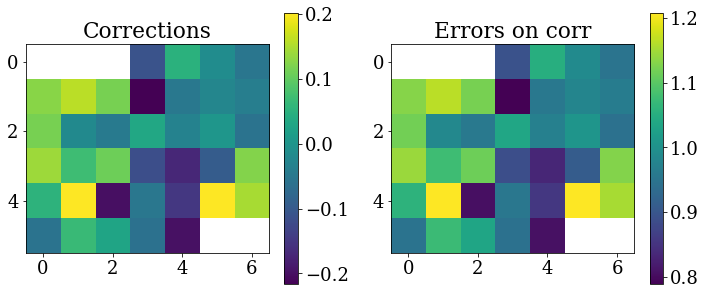

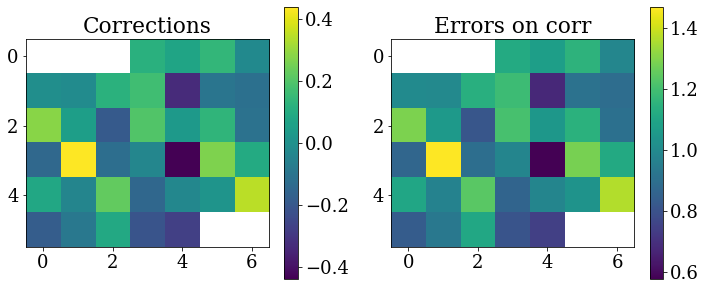

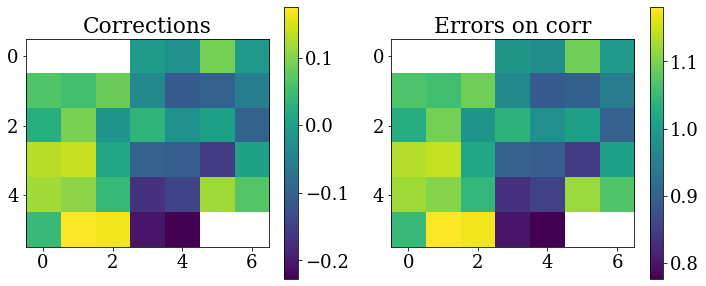

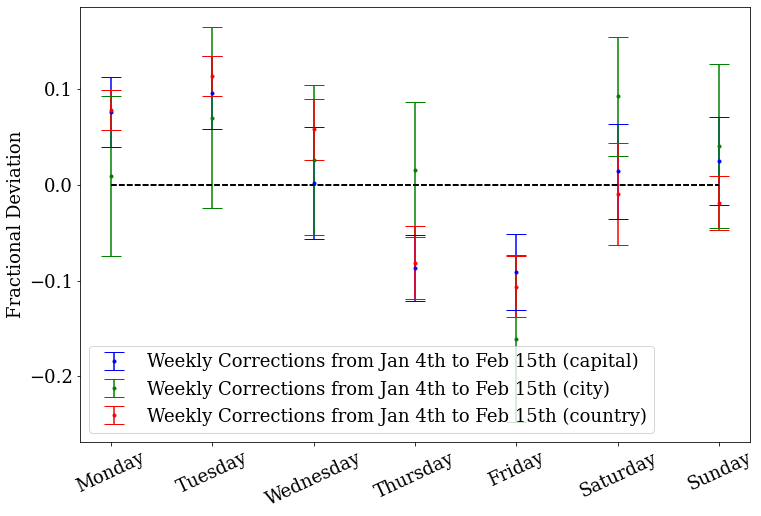

In [49]:
# Use on the third period (for all three regions)
f_cap, e_cap = week_correction(dato_start='2021-01-04', dato_end='2021-02-15', gamma=g3, egamma=g3_std, region=capital)
f_city, e_city = week_correction(dato_start='2021-01-04', dato_end='2021-02-15', gamma=g3, egamma=g3_std, region=city)
f_con, e_con = week_correction(dato_start='2021-01-04', dato_end='2021-02-15', gamma=g3, egamma=g3_std, region=country)

# Lets visualize it
fig, ax = plt.subplots(figsize=(12,8))
week_corr_plotter(f_cap, e_cap, ax,'Weekly Corrections from Jan 4th to Feb 15th (capital)', col='blue')
week_corr_plotter(f_city, e_city, ax,'Weekly Corrections from Jan 4th to Feb 15th (city)', col='green')
week_corr_plotter(f_con, e_con, ax,'Weekly Corrections from Jan 4th to Feb 15th (country)', col='red')

Her har vi brugt korretion funktionen på den sidste periode for henholdsvis byer, Storkøbenhavn og landområder. Bemærk at de korrektioner som plottes er resultatet af et alm mean (og altså ikke det weighted average, da vi endnu ikke har bestemt hvilken metode der er bedst). Det ligner at kategorien byer ikke er ensformig, når man kigger på kollonnerne er der større forskel i farver og chi2 er generelt en faktor 10 højere end henholdsvis storkøbenhavn og landområder. Dette skyldes nok at der kun er inkluderet fire kommuner, som geografisk er spredt udover Danmark, og derfor ikke nødvendigvis har meget med hinanden at gøre. En kommune som Esbjerg f.eks. dækker også over meget mere end Esbjerg by og kan derfor måske have forskellige adfærd opsamlet. Jeg tror den bedste inddeling er københavn og resten af danmark umiddelbart.